In [ ]:
from google.colab import drive

drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
DIRECTORY = "gdrive/My Drive/train"
CATEGORIES=["yID","nID"]

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import os

INIT_LR = 1e-4
EPOCHS = 20
BS = 32

print("[INFO] loading images...")

data = []
labels = []

for category in CATEGORIES:
    path = os.path.join(DIRECTORY, category)
    for img in os.listdir(path):
    	img_path = os.path.join(path, img)
    	image = load_img(img_path, target_size=(224, 224))
    	image = img_to_array(image)
    	image = preprocess_input(image)

    	data.append(image)
    	labels.append(category)

[INFO] loading images...


In [ ]:
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)

data = np.array(data, dtype="float32")
labels = np.array(labels)

(trainX, testX, trainY, testY) = train_test_split(data, labels,
	test_size=0.20, stratify=labels, random_state=42)

# construct the training image generator for data augmentation
aug = ImageDataGenerator(
	rotation_range=20,
	zoom_range=0.15,
	width_shift_range=0.2,
	height_shift_range=0.2,
	shear_range=0.15,
	horizontal_flip=True,
	fill_mode="nearest")

# load the MobileNetV2 network, ensuring the head FC layer sets are
# left off
baseModel = MobileNetV2(weights="imagenet", include_top=False,
	input_tensor=Input(shape=(224, 224, 3)))

# construct the head of the model that will be placed on top of the
# the base model
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(7, 7))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(128, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(2, activation="softmax")(headModel)

model = Model(inputs=baseModel.input, outputs=headModel)


for layer in baseModel.layers:
	layer.trainable = False


print("[INFO] compiling model...")
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="binary_crossentropy", optimizer=opt,
	metrics=["accuracy"])


print("[INFO] training head...")
H = model.fit(
	aug.flow(trainX, trainY, batch_size=BS),
	steps_per_epoch=len(trainX) // BS,
	validation_data=(testX, testY),
	validation_steps=len(testX) // BS,
	epochs=EPOCHS)


predIdxs = model.predict(testX, batch_size=BS)
predIdxs = np.argmax(predIdxs, axis=1)

print(classification_report(testY.argmax(axis=1), predIdxs,
	target_names=lb.classes_))

print("[INFO] saving ID detector model...")
model.save("ID_detector.model", save_format="h5")

9406464/9406464 [==============================] - 0s 0us/step
[INFO] compiling model...
[INFO] training head...


/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/20
30/30 [==============================] - 54s 2s/step - loss: 0.6684 - accuracy: 0.6635 - val_loss: 0.4488 - val_accuracy: 0.9583
Epoch 2/20
30/30 [==============================] - 50s 2s/step - loss: 0.4494 - accuracy: 0.8594 - val_loss: 0.2990 - val_accuracy: 0.9792
Epoch 3/20
30/30 [==============================] - 49s 2s/step - loss: 0.3303 - accuracy: 0.9208 - val_loss: 0.2151 - val_accuracy: 0.9750
Epoch 4/20
30/30 [==============================] - 49s 2s/step - loss: 0.2629 - accuracy: 0.9354 - val_loss: 0.1603 - val_accuracy: 0.9792
Epoch 5/20
30/30 [==============================] - 48s 2s/step - loss: 0.2243 - accuracy: 0.9490 - val_loss: 0.1217 - val_accuracy: 0.9833
Epoch 6/20
30/30 [==============================] - 47s 2s/step - loss: 0.1733 - accuracy: 0.9719 - val_loss: 0.0969 - val_accuracy: 0.9833
Epoch 7/20
30/30 [==============================] - 49s 2s/step - loss: 0.1530 - accuracy: 0.9698 - val_loss: 0.0796 - val_accuracy: 0.9833
Epoch 8/20
30/30 [==

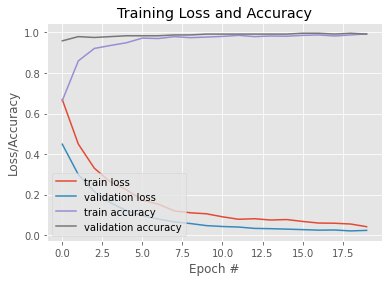

In [ ]:
N = EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="validation loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train accuracy")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="validation accuracy")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig("plot.png")

In [ ]:
model.save("gdrive/My Drive/train/ID_detector.model", save_format="h5")

In [ ]:
np.array(data)[0].shape

(224, 224, 3)